In [10]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('data/kidney_disease.csv')
df.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


## Data Analysis

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             330 non-null    object 
 17  wc              295 non-null    obj

In [12]:
df.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


<Axes: >

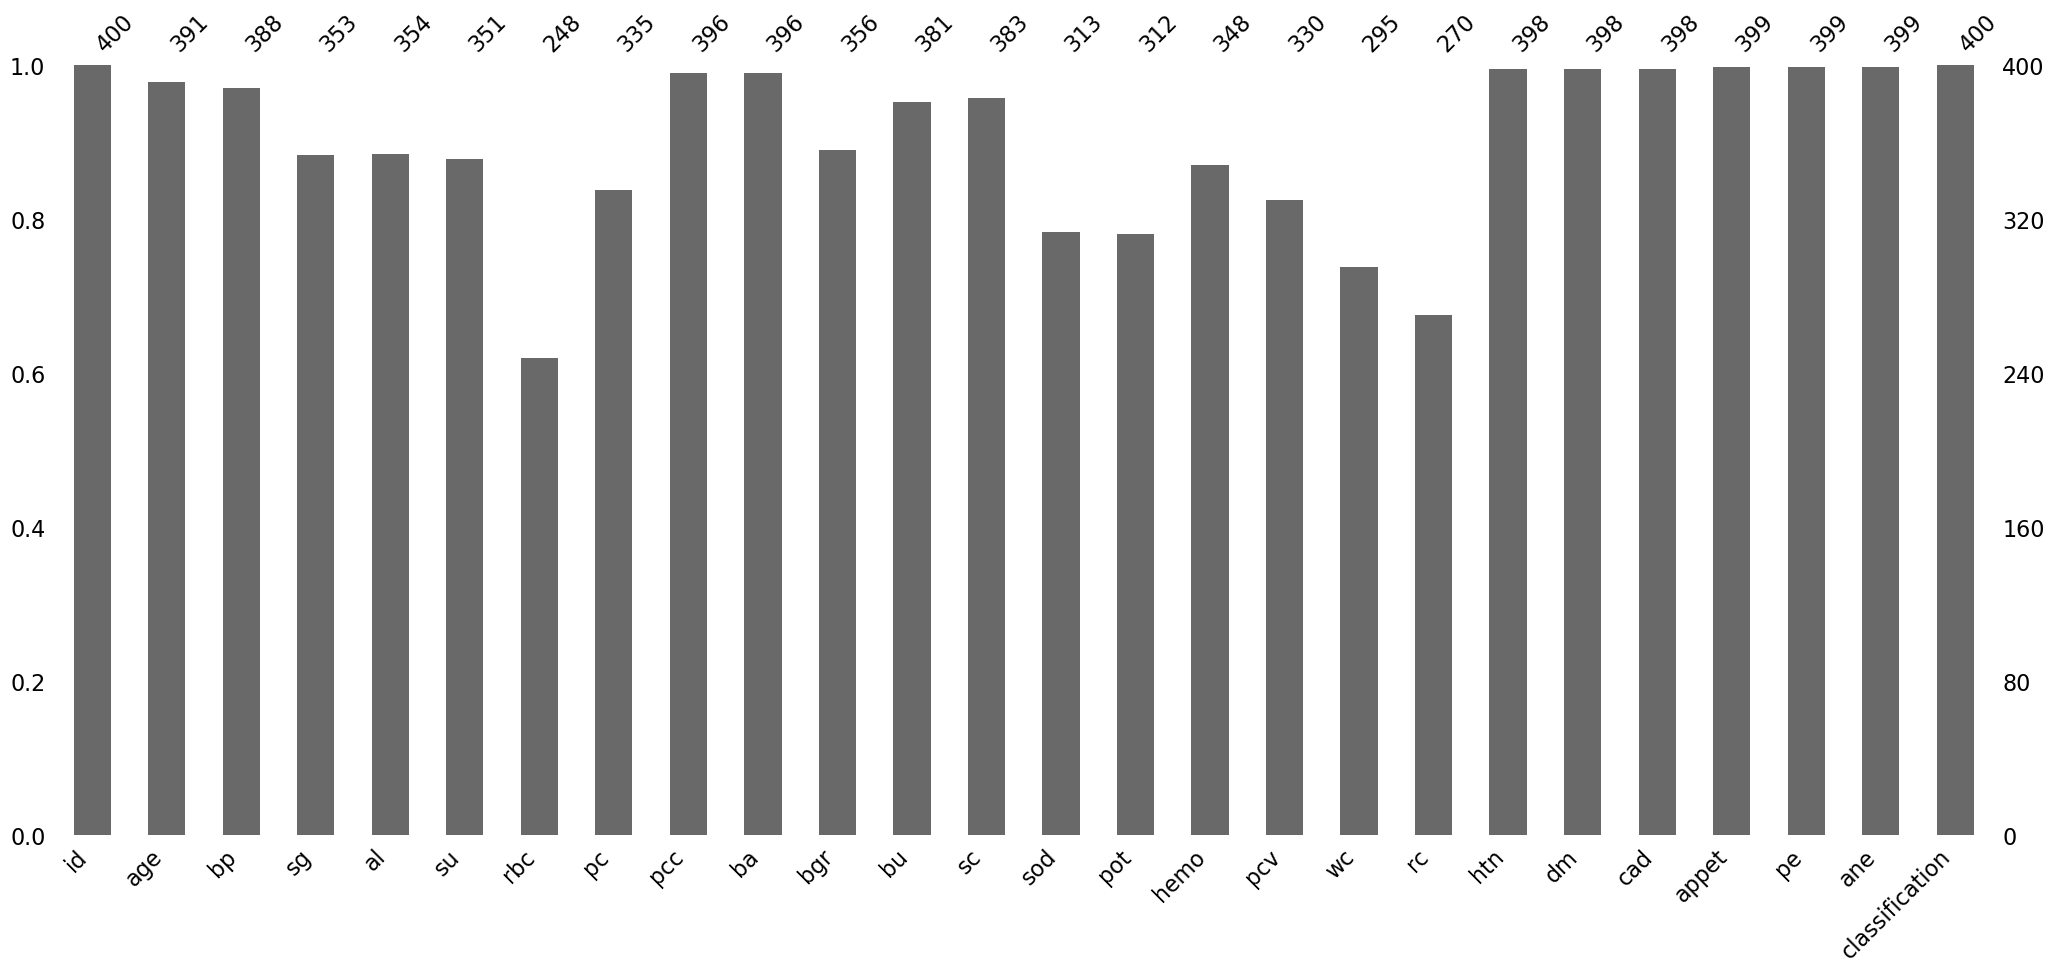

In [13]:
import seaborn as sns
import pandas as pd
import missingno as msno
%matplotlib inline
msno.bar(df)

<Axes: >

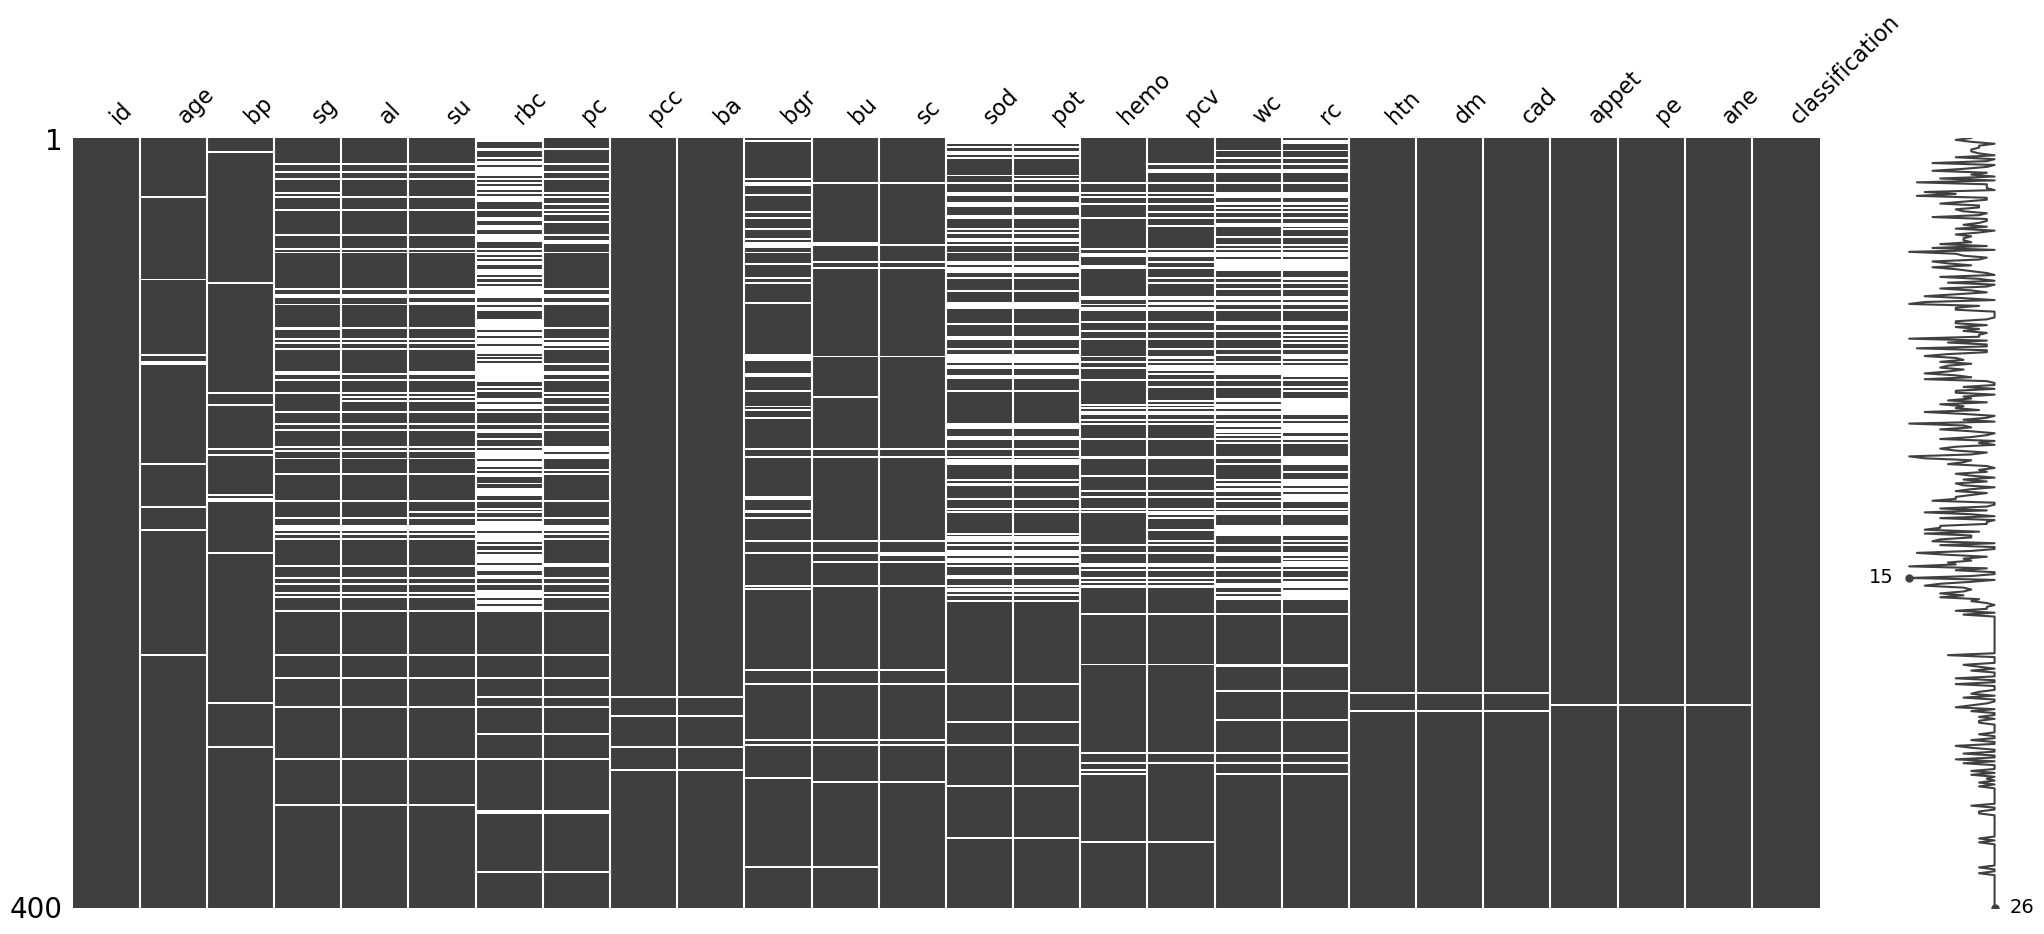

In [14]:
msno.matrix(df)

## Data Labeling and Prepocessing

In [15]:
df.nunique()

id                400
age                76
bp                 10
sg                  5
al                  6
su                  6
rbc                 2
pc                  2
pcc                 2
ba                  2
bgr               146
bu                118
sc                 84
sod                34
pot                40
hemo              115
pcv                44
wc                 92
rc                 49
htn                 2
dm                  5
cad                 3
appet               2
pe                  2
ane                 2
classification      3
dtype: int64

In [20]:
from sklearn.preprocessing import LabelEncoder
df.drop('id',axis=1,inplace=True)

le = LabelEncoder()

for col in df.select_dtypes(include=['object', 'category']).columns:
    df[col] = le.fit_transform(df[col])
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,2,1,0,0,121.0,...,32,72,34,1,4,1,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,2,1,0,0,NaN,...,26,56,49,0,3,1,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,1,1,0,0,423.0,...,19,70,49,0,4,1,1,0,1,0
3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,117.0,...,20,62,19,1,3,1,1,1,1,0
4,51.0,80.0,1.010,2.0,0.0,1,1,0,0,106.0,...,23,68,27,0,3,1,0,0,0,0


Dropped *id* column since it's unecessary and used regural LabelEncoder since there are no more than 3 or 2 classes, and if I would use OneHotEncoder, I'd have problems with dimensionality.

## Model Training and Comparing

In [21]:
from sklearn.impute import SimpleImputer
from reparo import CDI, FRNNI, HotDeckImputation, KNNImputer, PMM, SICE, MICE
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

imputers = [
    SimpleImputer(strategy='median'),
    SimpleImputer(strategy='mean'),
    SimpleImputer(strategy='most_frequent'),
    SimpleImputer(strategy='constant', fill_value=0),
    CDI(),
    FRNNI(),
    HotDeckImputation(),
    KNNImputer(),
    PMM(),
    SICE(),
    MICE()
]

models = [
    LinearRegression(),
    GaussianNB(),
    DecisionTreeRegressor(),
    RandomForestRegressor()
]

y = df['classification']
X = df.drop('classification', axis=1)
columns = ['Imputation Algorithms', 'Prediction algorithm', 'Accuracy']
table = pd.DataFrame(columns=columns)

for i, imputer in enumerate(imputers): #algorithm for iterating took from a foreign github
    if i < 4:
        imputed_X = imputer.fit_transform(X)
        imputed_X = pd.DataFrame(imputed_X, columns=X.columns)
    else:
        imputed_X = X.copy()
        imputer.apply(imputed_X, imputed_X.columns)

    X_train, X_test, y_train, y_test = train_test_split(imputed_X, y, test_size=0.1, random_state=42)

    for model in models:
        model_str = str(model).split('(')[0]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = model.score(X_test, y_test)

        table = pd.concat([table, pd.DataFrame([[imputer, model_str, accuracy]], columns=columns)], ignore_index=True)

table = table.sort_values(by=['Accuracy'], ascending=False)
table

,Imputation Algorithms,Prediction algorithm,Accuracy
22,FRNNI(),DecisionTreeRegressor,1.000000
10,SimpleImputer(strategy='most_frequent'),DecisionTreeRegressor,1.000000
18,CDI(),DecisionTreeRegressor,1.000000
26,HotDeckImputation(),DecisionTreeRegressor,1.000000
33,PMM(),GaussianNB,0.975000
37,SICE(),GaussianNB,0.975000
9,SimpleImputer(strategy='most_frequent'),GaussianNB,0.975000
1,SimpleImputer(strategy='median'),GaussianNB,0.975000
25,HotDeckImputation(),GaussianNB,0.975000
13,"SimpleImputer(fill_value=0, strategy='constant')",GaussianNB,0.975000


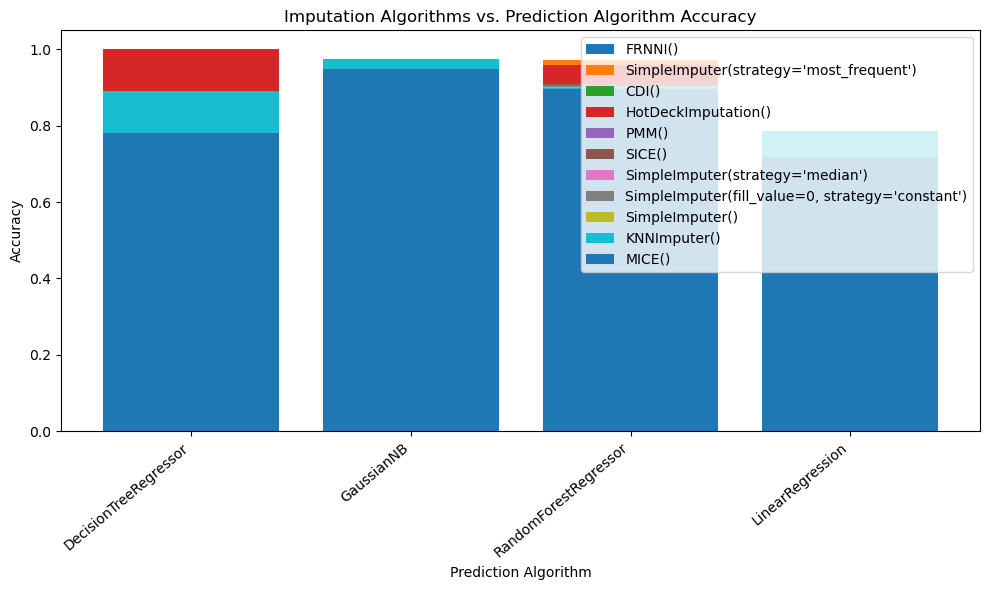

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

for algo in table['Imputation Algorithms'].unique():
    algo_data = table[table['Imputation Algorithms'] == algo]
    ax.bar(algo_data['Prediction algorithm'], algo_data['Accuracy'], label=str(algo))

ax.set_xlabel('Prediction Algorithm')
ax.set_ylabel('Accuracy')
ax.set_title('Imputation Algorithms vs. Prediction Algorithm Accuracy')
plt.xticks(rotation=40, ha='right')
ax.legend()


plt.tight_layout()
plt.show()

*Note: A lot of inputation algs got the same results thus they overlayed in the plot*

In case of DecisionTreeRegressor, the HotDeckImputation had the best accuracy along with KNNImputer(). Same situation is represented in the case of GaussianNB. If talking about RandomForestRegressor, the SimpleImputer won. As a final note, the Linear Regression had also KNNImputer on top, however the accuracy of the model were smaller than average.